# Forecasting a causal interference

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#modelos
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Data:  (325, 3)
Columns:  ['VolksWagen', 'BMW', 'Allianz']
Período pré intervenção: 02/01/2011 à 13/09/2015
Período pós intervenção: 20/09/2015 à 19/03/2017


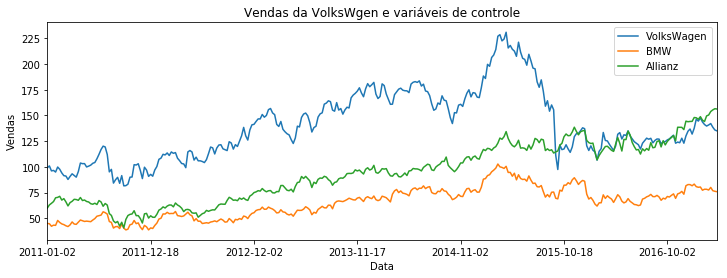

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/dafiti/causalimpact/master/tests/fixtures/volks_data.csv', header=0, sep=' ', index_col='Date')
print('Data: ', data.shape)
print('Columns: ', list(data.columns))
print('Período pré intervenção: 02/01/2011 à 13/09/2015')
print('Período pós intervenção: 20/09/2015 à 19/03/2017')
data.plot(figsize=(12,4))
plt.title('Vendas da VolksWgen e variáveis de controle')
plt.xlabel('Data')
plt.ylabel("Vendas")
plt.show()

## Regressão linear

Desejo inicialmente verificar a existência de uma relação entre os dados da BMW e da Allianz com os dados da VolksWagen no período pré intervenção, para isto irei utilizar de uma regressão linear.

In [3]:
pre_interv = ['2011-01-02', '2015-09-13']
pos_interv = ['2015-09-20', '2017-19-03']
lm = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data.loc[pre_interv[0]:pre_interv[1], 'BMW':'Allianz'], 
                                                    data.loc[pre_interv[0]:pre_interv[1], 'VolksWagen'], 
                                                    test_size = 0.25)
lm.fit(x_train, y_train)
print('R²: ', lm.score(x_test, y_test))
print('Coefs:')
print('BMW: ', lm.coef_[0])
print('Allianz: ', lm.coef_[1])

R²:  0.9115242789270744
Coefs:
BMW:  1.6947892815766648
Allianz:  0.4262398972975718


Vimos que podemos encontrar uma relação entre os dados com um R² de 0.9, vamos verificar como esta relação se mantém no período pós intervenção.

In [4]:
lm = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data.loc[pos_interv[0]:pos_interv[1], 'BMW':'Allianz'], 
                                                    data.loc[pos_interv[0]:pos_interv[1], 'VolksWagen'], 
                                                    test_size = 0.25)
lm.fit(x_train, y_train)
print('R²: ', lm.score(x_test, y_test))
print('Coefs:')
print('BMW: ', lm.coef_[0])
print('Allianz: ', lm.coef_[1])

R²:  0.43809713728583843
Coefs:
BMW:  -0.1986014177065233
Allianz:  0.5946681833943629


Observa-se que de fato esta relação não está represente no período pós intervenção como é visível no gráfico.

O primeiro método para tentar predizer o comportamento da variável após o período de intervenção será utilizar uma regressão linear com as seguintes variáveis:

- Ano e mês para tentar considerar a periodicidade
- Valores das variáveis auxiliares antes do período de intervenção
- E o nosso target será os valores da VolksWagen antes do período de intervenção

In [5]:
mes = data.reset_index().Date.apply(lambda x : int(x[5:7]))
dia = data.reset_index().Date.apply(lambda x : int(x[8:10]))
ano = data.reset_index().Date.apply(lambda x : int(x[0:4]))
dia.index = mes.index = ano.index = data.index
lm_data1= pd.DataFrame(index = data.index, data = {'dia': dia, 'mes': mes, 'ano': ano, 
                        'BMW': data.BMW, 
                        'Allianz': data.Allianz, 
                        'VolksWagen': data.VolksWagen})
lm_data1.head()

,dia,mes,ano,BMW,Allianz,VolksWagen
Date,,,,,,
2011-01-02,2,1,2011,45.039032,60.006882,99.142822
2011-01-09,9,1,2011,44.758060,63.032661,100.908623
2011-01-16,16,1,2011,42.297653,64.578583,96.084999
2011-01-23,23,1,2011,43.360786,66.296272,96.558739
2011-01-30,30,1,2011,43.170944,69.962891,94.965218


R²: 0.9358326880446198
Coefs: 
	 dia :  -0.06835809255013998
	 mes :  0.34076251228037446
	 ano :  3.689859573810093
	 BMW :  1.5220587243864376
	 Allianz :  0.3292525670406563


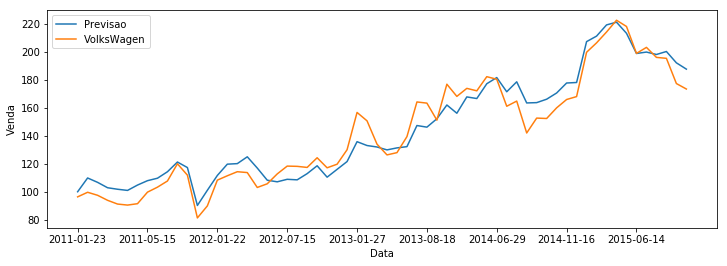

In [6]:
lm = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(lm_data1.loc[pre_interv[0]:pre_interv[1],'dia':'Allianz'],
                                                    lm_data1.loc[pre_interv[0]:pre_interv[1],'VolksWagen'],
                                                    test_size = 0.25, shuffle = True)
lm.fit(x_train, y_train)
print('R²:', lm.score(x_test, y_test))
print('Coefs: ')
for i in range(len(lm.coef_)):
    print('\t', x_train.columns[i], ': ', lm.coef_[i])
k = 0
x_axis1 = []
fig1 = plt.figure(figsize = (12,4))
for i in y_test.sort_index().index:
    if (k % 7 ==0):
        x_axis1.append(i)
    k+=1    
plt.plot(lm.predict(x_test.sort_index()), label = "Previsao")
plt.plot(y_test.sort_index())
plt.xlabel('Data')
plt.ylabel('Venda')
plt.legend()
plt.xticks(x_axis1)
plt.show()

Tentando agora prever o comportamento pós intervenção.

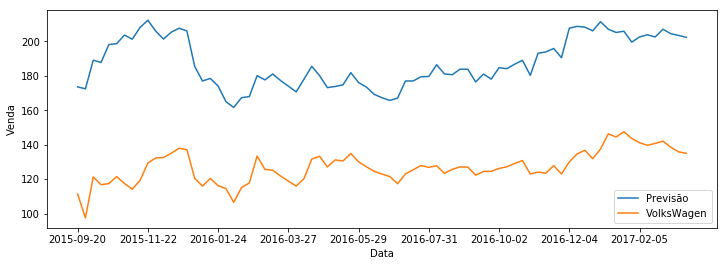

In [7]:
x = lm_data1.loc[pos_interv[0]:pos_interv[1],'dia':'Allianz']
y = lm_data1.loc[pos_interv[0]:pos_interv[1],'VolksWagen']
x_axis2 = []
k = 0
for i in y.index:
    if(k % 9 == 0):
        x_axis2.append(i)
    k+= 1
fig2 = plt.figure(figsize = (12,4))
plt.plot(lm.predict(x), label = "Previsão")
plt.plot(y)
plt.xticks(x_axis2)
plt.xlabel('Data')
plt.ylabel('Venda')
plt.legend()
plt.show()

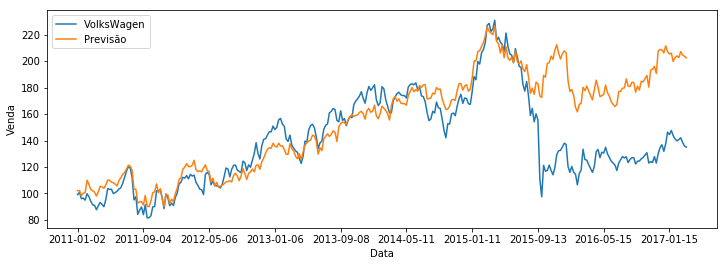

In [8]:
fig3 = plt.figure(figsize = (12,4))
plt.plot(data.VolksWagen)
prev = list(lm.predict(lm_data1.loc[pre_interv[0]:pre_interv[1],'dia':'Allianz']))+ list(lm.predict(x))
x_axis3 = []
k = 0
for i in data.index:
    if(k % 35 == 0):
        x_axis3.append(i)
    k+= 1
plt.xticks(x_axis3)
plt.xlabel('Data')
plt.ylabel('Venda')
plt.plot(data.index, prev, label = 'Previsão')
plt.legend()
plt.show()

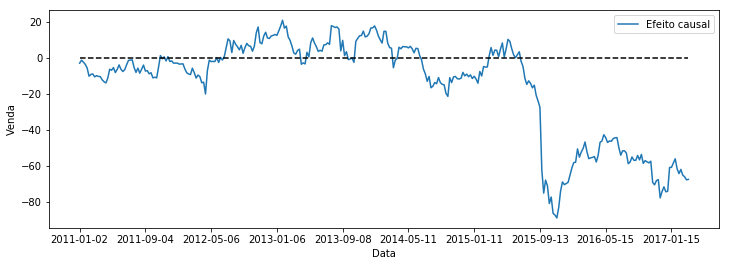

In [24]:
fig3 = plt.figure(figsize = (12,4))
plt.plot(data.index, data.VolksWagen - prev, label = 'Efeito causal')
z = np.zeros([len(prev),1])
plt.plot(z, c = 'black', label = "_nolabel_", linestyle = 'dashed')
plt.xticks(x_axis3)
plt.xlabel('Data')
plt.ylabel('Venda')
plt.legend()
plt.show()